<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">2024-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PAC2: Deep Reinforcement Learning


En aquesta pràctica s'implementaran models de DRL en dos entorns diferents, amb l'objectiu d'analitzar diferents formes d'aprenentatge d'un agent i estudiar-ne el rendiment. L'agent serà entrenat amb els mètodes:
<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
</ol>
  
**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi, els resultats i comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File → Download as → HTML.**

## 0. Context

L'aprenentatge per reforç és un camp de la intel·ligència artificial que cerca desenvolupar sistemes capaços d'aprendre i prendre decisions autònomes a través de la interacció amb el seu entorn. Al llarg dels anys aquest enfocament ha demostrat la seva capacitat per abordar una àmplia gamma d'aplicacions, des de jocs de taula fins a robòtica i gestió de recursos. Tot i això, una de les qüestions més desafiadores en l'aprenentatge per reforç és la creació d'entorns de simulació adequats que reflecteixin fidelment el context de l'aplicació desitjada.


En aquest context, aquesta PAC té com a objectiu desenvolupar un nou entorn de simulació que permeti la investigació i l'experimentació amb diferents agents de trading. Aquest entorn estarà dissenyat específicament per abordar un problema fictici d'inversió i gestió d'un portafoli al mercat de valors, en el que un agent ha d'aprendre a prendre decisions òptimes de compra, venda o manteniment d'accions. L'objectiu de l'agent serà maximitzar els guanys al llarg del temps mitjançant estratègies basades en l'aprenentatge per reforç.

Per a portar-ho a terme, s'utilitzarà un entorn adaptat a les especificacions de Gymnasium (https://gymnasium.farama.org/index.html), que permet la creació d'entorns personalitzats per a l'aprenentatge per reforç. Aquest entorn simularà el comportament dinàmic d'un mercat financer, amb fluctuacions en els preus de les accions i esdeveniments del mercat que afecten les decisions de l'agent.


## 1. Creació d'un entorn en Gym (3 punts)

En aquest exercici dissenyem un entorn senzill seguint l'esquema dels entorns de <code>Gymnasium</code>, i tractarem de resoldre'l.

Els entorns de <code>Gymnasium</code> acostumen a tenir la següent estructura:

```
class FooEnv(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self):
    ...
  def step(self, action):
    ...
    return new_state, reward, terminated, truncated, info

  def reset(self):
    ...
    return observation, info

  def render(self, mode='human', close=False):
    ...

 ```


El primer pas serà instal·lar les llibreries necessàries per abordar la PAC:


In [1]:
!pip install gymnasium
!pip install torch

!pip install matplotlib
!pip install numpy
!pip install tensorboard
!pip install tdqm
!pip install tabulate
!pip install yfinance==0.2.50
!pip install pandas

y las importamos:

In [2]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from gymnasium.spaces import Discrete, Box
from collections import namedtuple, deque
from copy import deepcopy
import math
import time
import torch
import torch.nn.functional as F
from tabulate import tabulate
import pandas as pd
import yfinance as yf
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Gym Version:", gym.__version__)  # 1.0.0
print("Torch Version:", torch.__version__)  # 2.5.1+cu121

Gym Version: 1.0.0
Torch Version: 2.5.1+cu121


### 1.1 Entorn de Simulació per al Trading Automàtic al Mercat de Valors

**Enhorabona!** Una firma d'inversió ha decidit contractar-vos per desenvolupar un sistema de trading automàtic per a les seves operacions al mercat de valors. Per a això, us demanen que dissenyeu un entorn de simulació que permeti entrenar un agent capaç de prendre decisions de compra, venda o mantenir posicions sobre una acció determinada, maximitzant els guanys al llarg del temps. L'entorn ha de complir les següents especificacions:

- L'entorn s'ha d'anomenar `StockMarketEnv`.
- L'entorn ha d'heretar de la classe `gym.Env`.
- El preu inicial de l'acció estarà basat en dades històriques, obtingudes a partir d'una consulta a Yahoo Finance.
- El balanç inicial de l'agent serà de 10.000 dòlars, els quals es podran utilitzar per comprar accions.
- L'agent pot realitzar les següents accions:
  - `0` -> Mantenir (no es realitzen operacions).
  - `1` -> Comprar (es compren totes les accions possibles al preu actual).
  - `2` -> Vendre (es venen totes les accions disponibles al preu actual).
- El sistema de recompenses serà el següent:
  - L'agent rep una recompensa de +1 si el valor net del seu portafoli (balanç_actual + balanç_anterior) augmenta respecte al pas anterior.
  - L'agent rep una recompensa de +1 si el valor net del seu portafoli (balanç_actual) es manté igual, no posseeix cap acció i el valor de les accions disminueix. Aquesta comprovació no es realitza el primer dia de trading.
  - L'agent rep una recompensa de -1 si el valor net del seu portafoli (balanç_actual) es manté igual, no posseeix cap acció i el valor de les accions augmenta respecte al dia anterior. Aquesta comprovació no es realitza el primer dia de trading.
  - Si el valor net disminueix respecte al dia anterior, l'agent rep una recompensa de -1.
  - En altres casos, rep una puntuació de 0.
- L'entorn tindrà una durada per defecte per a l'entrenament del `2019-01-01` al `2021-01-01`.
- L'entorn finalitzarà si el valor net del portafoli cau per sota del 85% del balanç inicial (és a dir, 8.500 dòlars).

L'objectiu d'aquest entorn és que l'agent aprengui a prendre decisions òptimes de compra i venda.



![Imagen de Stock Market](https://media1.tenor.com/m/wWvt6qEQB8EAAAAd/kah.gif)

#### 1.1.1 Implementació dels indicadors econòmics

El primer pas és implementar dues funcions anomenadaes `calculate_rsi` i `calculate_ema` que calcularan diferents indicadors tècnics utilitzats en l'anàlisi de mercats financers. Aquests indicadors ajudaran els agents de trading a prendre decisions basades en patrons i tendències del mercat.

A continuació, s'explica en què consisteixen aquestes mètriques:

- **RSI (Índex de Força Relativa)**: Calcula l'RSI utilitzant el canvi de preu durant una finestra de temps especificada. Aquest indicador mostra si un actiu està sobrecomprat o sobrevenut. Podeu veure una explicació més detallada a https://es.wikipedia.org/wiki/%C3%8Dndice_de_fuerza_relativa
- **EMA (Mitjana Mòbil Exponencial)**: Calcula l'EMA, que és una versió ponderada de la mitjana mòbil que dóna més pes als preus recents. Podeu veure una explicació més de tallada a https://es.tradingview.com/support/solutions/43000592270/

Les funcions prenen alguns dels següents arguments:

- `data`: Les dades històriques de preus de les accions, generalment en format de sèries temporals. En aquest exemple, utilitzarem els preus de tancament diaris.
- `window` (opcional): El nombre de períodes a utilitzar per als càlculs dels indicadors. Per defecte, s'assumeix un valor de 14 per al RSI i l'EMA.

A continuació, es mostren les funcions:


In [3]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50).squeeze()

def calculate_ema(data, window=14):
    return data.ewm(span=window, adjust=False).mean().squeeze()


Amb aquestes funcions, els agents podran utilitzar informació tècnica clau sobre les accions al mercat per prendre decisions de trading més informades.

Ara bé, necessitem el valor de les accions. Per a aquest projecte, utilitzem la llibreria yfinance, que permet obtenir dades històriques d'actius financers de manera senzilla. El següent fragment de codi descarrega les dades de l'ETF SPY (un fons que segueix l'índex S&P 500) des de l'1 de gener de 2021 fins a l'1 de gener de 2022:

In [4]:


data = yf.download("SPY", start="2021-01-01", end="2022-01-01")

print(data)


[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker             SPY         SPY         SPY         SPY         SPY   
Date                                                                     
2021-01-04  348.299408  368.790009  375.450012  364.820007  375.309998   
2021-01-05  350.698212  371.329987  372.500000  368.049988  368.100006   
2021-01-06  352.794922  373.549988  376.980011  369.119995  369.709991   
2021-01-07  358.036591  379.100006  379.899994  375.910004  376.100006   
2021-01-08  360.076569  381.260010  381.489990  377.100006  380.589996   
...                ...         ...         ...         ...         ...   
2021-12-27  456.750946  477.260010  477.309998  472.010010  472.059998   
2021-12-28  456.377716  476.869995  478.809998  476.059998  477.720001   
2021-12-29  456.961487  477.480011  478.559998  475.920013  476.980011   
2021-12-30  455.698242  476.160004  479.000000  475.670013  477.929993   
2021-12-31  454.549774  474.959991  47

El resultat és un **DataFrame** que conté la següent informació per a cada dia del rang de dates:

- **Open**: Preu d'obertura de l'actiu.
- **High**: Preu màxim de l'actiu durant el dia.
- **Low**: Preu mínim de l'actiu durant el dia.
- **Close**: Preu de tancament de l'actiu.
- **Adj Close**: Preu ajustat que té en compte dividends i splits.
- **Volume**: Nombre d'accions negociades.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.1 (0.25 pts):</strong>
    Utilitza les dades històriques del mercat financer, descarregades mitjançant la funció <code>yfinance.download</code>, i aplica els indicadors tècnics proporcionats: <code>calculate_rsi</code> i <code>calculate_ema</code>.
    A continuació, realitza les següents tasques:
    <ul>
        <li>Descarrega les dades històriques de SPY per a l'any 2021.</li>
        <li>Calcula l'RSI per als preus de tancament durant el període.</li>
        <li>Calcula la mitjana mòbil exponencial (EMA) per al mateix període amb els preus de tancament.</li>
        <li>Imprimeix l'últim valor dels càlculs de cada indicador (RSI i EMA) per verificar que s'han generat correctament sense errors. Aquests valors haurien de ser RSI: 53.765164 i EMA: 470.690088 (el nombre de decimals pot variar).</li>
    </ul>
</div>


In [6]:
pd.set_option('display.float_format','{:.2f}'.format)
data = yf.download("SPY", start="2021-01-01", end="2022-01-01",progress = False)

closing_prices = data['Close']

print("\nDatos históricos de SPY para el año 2021: ")
print(closing_prices.iloc[-1])

print("\nRSI: ")
print(calculate_rsi(closing_prices).iloc[-1])

print("\nEMA: ")
print(calculate_ema(closing_prices).iloc[-1])



Datos históricos de SPY para el año 2021: 
Ticker
SPY   474.96
Name: 2021-12-31 00:00:00, dtype: float64

RSI: 
53.76516415158352

EMA: 
470.6900882953319


#### 1.1.2 Implementació de StockMarketEnv

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.2 (2.25 pts):</strong> Defineix l'entorn <code>StockMarketEnv</code> seguint les indicacions aportades anteriorment.
    A més, a banda de les típiques funcions de qualsevol entorn (<code>reset</code>, <code>step</code> i <code>render</code>), s'han d'implementar dos funcions més (<code>save_to_csv_file</code> i <code>_normalize</code>) que s'expliquen a continuació:
</div>


##### Crear la funció <code>save_to_csv_file</code> en Python
Implementa una funció <code>save_to_csv_file</code> que guardi les dades actuals d'una classe en un fitxer CSV. La funció calcularà el benefici (<code>profit</code>) com la diferència entre el valor net actual (<code>net_worth</code> -> balanç efectiu + valor de les accions en possessió) i el balanç inicial (<code>initial_balance</code>), i escriurà una nova fila amb els valors de <code>current_step</code>, <code>balance</code>, <code>shares_held</code>, <code>net_worth</code> i <code>profit</code> en el fitxer CSV.



##### Crear la funció de normalització en Python

La funció `_normalize` s'utilitza per ajustar un valor a un rang estàndard, comunament entre 0 i 1, en relació amb un valor mínim i màxim especificats. Aquest procés, conegut com a **normalització**, és útil per transformar dades, mantenint les seves proporcions relatives, dins d'un interval més manejable. La funció pren tres paràmetres:

- `value`: el valor a normalitzar.
- `min_val`: el límit inferior del rang de normalització.
- `max_val`: el límit superior del rang de normalització.

La normalització es realitza mitjançant la següent fórmula:

$$
\text{normalized_value} = \frac{\text{value} - \text{min_val}}{\text{max_val} - \text{min_val}}
$$

Aquest càlcul ajusta `value` al rang definit entre `min_val` i `max_val`. A més, si `max_val` i `min_val` són iguals, la funció retorna `0` per evitar una **divisió per zero**.

##### Beneficis en el Context de l'Aprenentatge per Reforç (RL)

En un entorn d'**aprenentatge per reforç (RL)**, la normalització és fonamental per diverses raons:

1. **Estabilitat d'Entrenament**: Al normalitzar les recompenses, les observacions o les accions a un rang estàndard, s'evita que valors grans desestabilitzin el procés d'aprenentatge. Els models de RL, com les xarxes neuronals, tendeixen a aprendre millor amb dades en intervals limitats.

2. **Facilita la Comparació**: La normalització permet comparar dades provinents de diferents fonts o escales, com recompenses de diferents entorns, cosa que millora la generalització del model.

3. **Accelera la Convergència**: Dades escalades de manera uniforme ajuden que els algoritmes de RL convergeixin més ràpidament, ja que es redueix la variabilitat de les entrades.

4. **Prevé Errors de Càlcul**: En gestionar entrades normalitzades i amb límits definits, s'eviten errors de càlcul o inestabilitats degudes a diferències numèriques extremes.
----
<b>Nota</b>: se us proporciona el codi preimplementat. La implementació que es demana en l'enunciat està indicada en els blocs <i>#TODO</i> i/o amb variables igualades a <i>None</i>.

In [ ]:
import os
import csv

start = "2019-01-01"
end = "2021-01-01"
ticker = "SPY"
initial_balance = 10_000

class StockMarketEnv(gym.Env):
    def __init__(self, ticker=ticker, initial_balance=initial_balance,  is_eval = False,
                 start = start, end = end, save_to_csv=False,
                 csv_filename="stock_trading_log.csv"):
        super(StockMarketEnv, self).__init__()

        # Descarregar les dades històriques de l'acció
        self.df = yf.download(ticker, start=start, end=end, progress =False)
        self.num_trading_days = len(self.df)
        self.prices = self.df['Close'].values.squeeze()
        self.n_steps = len(self.prices)-1

        # Paràmetres de l'entorn
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.net_worth = initial_balance
        self.previprevius_net_worth = initial_balance

        # Espai d'accions: 0 -> mantenir, 1 -> comprar, 2 -> vendre
        self.action_space = Discrete(3)

        # Calculem els indicadors tècnics
        self.rsi = calculate_rsi(self.df['Close'])
        self.ema = calculate_ema(self.df['Close'])


        # Espai d'observacions: [preu_actual, balanç, accions, rsi, ema, sma, upper_band, lower_band]
        self.observation_space = Box(low=0, high=np.inf, shape=(5,), dtype=np.float32)
        self.is_eval = is_eval

        # Valores para normalización (obtenemos mínimos y máximos)
        self.min_price = np.min(self.prices)
        self.max_price = np.max(self.prices)

        self.min_rsi = np.min(self.rsi)
        self.max_rsi = np.max(self.rsi)

        self.min_ema = np.min(self.ema)
        self.max_ema = np.max(self.ema)


        # Paràmetres addicionals per al fitxer CSV
        self.save_to_csv = save_to_csv
        self.csv_filename = csv_filename

        # Si l'opció de desar en CSV està activada, crea o sobreescriu el fitxer
        if self.save_to_csv:
            if os.path.exists(self.csv_filename):
                os.remove(self.csv_filename)
            with open(self.csv_filename, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Step", "Balance", "Shares Held", "Net Worth", "Profit"])


    def reset(self):
        self.balance = self.initial_balance
        self.previous_net_worth = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.current_step = 0
        return self._next_observation(),{}

    def _normalize(self, value, min_val, max_val):
        normalized_value = (value - min_val) / (max_val - min_val) if max_val != min_val else 0
        # Verifica si el resultat és un array o llista amb un únic element
        if isinstance(normalized_value, (np.ndarray, list)) and len(normalized_value) == 1:
            # Si és un array o llista d'un sol valor, torna aquest valor escalar
            return normalized_value[0]

        # En cas contrari, torna el valor normalitzat (pot ser escalar o array)
        return normalized_value

    def _next_observation(self):
        #  Normalitzem els valors
        norm_price = self._normalize(self.prices[self.current_step], self.min_price, self.max_price)
        norm_balance = self._normalize(self.balance, self.initial_balance * 0.85, self.initial_balance * 1.25)
        norm_shares_held = self._normalize(self.shares_held, 0, 100)  # Màxim de 100 accions
        norm_rsi = self._normalize(self.rsi[self.current_step], self.min_rsi, self.max_rsi)
        norm_ema = self._normalize(self.ema[self.current_step], self.min_ema, self.max_ema)

        return np.array([
            norm_price,
            norm_balance,
            norm_shares_held,
            norm_rsi,
            norm_ema,
        ])


    def step(self, action):
        current_price = self.prices[self.current_step]
        reward = 0

        # Acció: 0 -> mantenir, 1 -> comprar, 2 -> vendre
        if action == 1:  # Comprar
            while self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price

        elif action == 2:  # Vendre
            while self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price

        # Actualitzar el patrimoni net
        self.net_worth = self.balance + self.shares_held * current_price

        # Recompensa: patrimoni net anterior i actual.
        if self.net_worth > self.previous_net_worth:
            reward = 1
        elif self.net_worth < self.previous_net_worth:
            reward = -1
        elif self.shares_held == 0 and self.current_step > 0:
            if current_price < self.prices[self.current_step - 1]:
                reward = 1
            elif current_price > self.prices[self.current_step - 1]:
                reward = -1

        # Actualitzar el patrimoni anterior
        self.previous_net_worth = self.net_worth

        # Avançar al següent pas
        self.current_step += 1
        terminated = self.current_step >= self.n_steps
        truncated = self.net_worth < self.initial_balance* 0.85

        if self.save_to_csv:
            self.save_to_csv_file()

        #Retorna l'observació, la recompensa, si està complet, i altra informació addicional
        return self._next_observation(), reward, terminated, truncated, {}

    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')




    # La funció save_to_csv_file desa les dades actuals en un fitxer CSV.
    # 1. Primer calcula el benefici com la diferència entre el valor net
    # actual i el balanç inicial.
    # 2. Després, obre (o crea) el fitxer CSV en mode 'append' per afegir
    # una nova fila de dades sense sobrescriure les anteriors.
    # 3. Escriu una nova fila al CSV amb els valors del pas actual,
    # balanç, accions mantingudes, valor net i el benefici.
    # Step,Balance,Shares Held,Net Worth,Profit
    # 1,12000,50,13000,3000
    def save_to_csv_file(self):
        """Desa les dades actuals al fitxer CSV."""
        profit = self.net_worth - self.initial_balance
        with open(self.csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([self.current_step, self.balance, self.shares_held, self.net_worth, profit])


La següent cel·la és de **comprovació** i ha de generar la sortida que es mostra a continuació. Aquesta sortida serveix per verificar que tot s'ha implementat correctament. En executar la cel·la, la sortida ha de coincidir exactament amb el resultat següent:


```
------------------------------------------------------------------------------------
(array([0.14086006, 0.375     , 0.        , 0.45140651, 0.        ]), 0, False, False, {})
------------------------------------------------------------------------------------
(array([ 0.19505732, -2.06710007,  0.4       ,  0.45140651,  0.00333123]), 0, False, False, {})
------------------------------------------------------------------------------------
(array([ 0.20824227, -2.06710007,  0.4       ,  0.45140651,  0.00842359]), 1, False, False, {})
------------------------------------------------------------------------------------
(array([0.22407732, 0.47669998, 0.        , 0.45140651, 0.01548553]), 1, False, False, {})
------------------------------------------------------------------------------------
Step: 4  
Balance: 10406.799926757812  
Shares held: 0  
Net worth: 10406.799926757812  
Profit: 406.7999267578125  
None  
------------------------------------------------------------------------------------
(array([0.23202811, 0.47669998, 0.        , 0.45140651, 0.02293572]), -1, False, False, {})
------------------------------------------------------------------------------------
Step: 5  
Balance: 10406.799926757812  
Shares held: 0  
Net worth: 10406.799926757812  
Profit: 406.7999267578125  
None  
------------------------------------------------------------------------------------
(array([ 0.23805742, -2.10300003,  0.4       ,  0.45140651,  0.03040101]), 0, False, False, {})
------------------------------------------------------------------------------------
Step: 6  
Balance: 87.9998779296875  
Shares held: 40  
Net worth: 10406.799926757812  
Profit: 406.7999267578125  
None  
------------------------------------------------------------------------------------
```

In [ ]:
env = StockMarketEnv()
env.reset()
print('------------------------------------------------------------------------------------')
print(env.step(0))
print('------------------------------------------------------------------------------------')
print(env.step(1))
print('------------------------------------------------------------------------------------')
print(env.step(1))
print('------------------------------------------------------------------------------------')
print(env.step(2))
print('------------------------------------------------------------------------------------')
print(env.render())
print('------------------------------------------------------------------------------------')
print(env.step(0))
print('------------------------------------------------------------------------------------')
print(env.render())
print('------------------------------------------------------------------------------------')
print(env.step(1))
print('------------------------------------------------------------------------------------')
print(env.render())
print('------------------------------------------------------------------------------------')



------------------------------------------------------------------------------------
(array([0.14086006, 0.375     , 0.        , 0.45140651, 0.        ]), 0, False, False, {})
------------------------------------------------------------------------------------
(array([ 0.19505732, -2.06710007,  0.4       ,  0.45140651,  0.00333123]), 0, False, False, {})
------------------------------------------------------------------------------------
(array([ 0.20824227, -2.06710007,  0.4       ,  0.45140651,  0.00842359]), 1, False, False, {})
------------------------------------------------------------------------------------
(array([0.22407732, 0.47669998, 0.        , 0.45140651, 0.01548553]), 1, False, False, {})
------------------------------------------------------------------------------------
Step: 4
Balance: 10406.799926757812
Shares held: 0
Net worth: 10406.799926757812
Profit: 406.7999267578125
None
------------------------------------------------------------------------------------
(arr

#### 1.1.3 Interacció amb l'Entorn StockMarketEnv

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.3 (0.5 pts):</strong> Carregar l'entorn <code>StockMarketEnv</code> i realitzar les següents tasques:
    <ul>
        <li>Mostrar l'espai d'accions i l'espai d'observacions.</li>
        <li>Executar 100 episodis amb accions aleatòries, mostrant la recompensa mitjana obtinguda entre totes les partides.</li>
        <li>Executar una partida aleatòria i mostrar el render en finalitzar-la.</li>
        <li>Provar la funció <code>save_to_csv_file</code> i mostrar el resultat de les darreres 5 files.</li>
    </ul>
</div>


In [ ]:
env = StockMarketEnv()

In [ ]:
# Espai d'accions
print("L'espai d'accions és {} ".format(env.action_space))

# Espai d'estats
print("L'espai d'estats és {} ".format(env.observation_space))

L'espai d'accions és Discrete(3) 
L'espai d'estats és Box(0.0, inf, (5,), float32) 


In [ ]:
episodes = 100
total_rewards = []
mean_reward = 0

for episode in range(1, episodes+1):
    state = env.reset()  # Reset the environment at the start of each episode
    done = False
    score = 0
    step = 0

    while not done:
        action = env.action_space.sample()  # Randomly sample an action
        n_state, reward, terminated, truncated, info = env.step(action)  # Take the action
        done = terminated or truncated  # Check if the episode is done
        score += reward  # Accumulate the reward
        step += 1

    total_rewards.append(score)  # Store the reward for the episode
    #print(f'Episode {episode} finished with score: {score}')
    #print('------------------------------------')

# Calculate and print the mean reward over all episodes
mean_reward = np.mean(total_rewards)
print(f'\nMean reward over {episodes} episodes: {mean_reward}')


Mean reward over 100 episodes: 14.51


In [ ]:
import time
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    step=0

    while not done:

        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        score+=reward
        step+=1
    print('------------------------------------')
env.render()

------------------------------------
Step: 504
Balance: 11134.18180847168
Shares held: 0
Net worth: 11134.18180847168
Profit: 1134.1818084716797


In [ ]:
def provar_save_to_csv(env, rows):
    """
    Provar la funció save_to_csv_file executant diverses accions
    a l'entorn i després mostrant les últimes 5 files del fitxer CSV.

    Paràmetres:
        env: L'entorn StockMarketEnv.
        rows: El número de files que es volen mostrar del fitxer CSV.
    """
    # Executar passos a l'entorn amb accions aleatòries
    env.reset()
    while True:
        action = env.action_space.sample()  # Genera una acción aleatoria
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

    # Llegir i mostrar les últimes x files del fitxer CSV
    if env.save_to_csv:
        # Llegir el fitxer CSV en un DataFrame
        csv_data = pd.read_csv(env.csv_filename)
        print("Darreres "+ str(rows) +" files de l'arxiu CSV:")
        print(csv_data.tail(rows))

env = StockMarketEnv(ticker="SPY", start="2019-01-01", end="2022-01-01", save_to_csv=True, csv_filename="stock_trading_log.csv")
provar_save_to_csv(env, 5)



Darreres 5 files de l'arxiu CSV:
     Step  Balance  Shares Held  Net Worth  Profit
751   752 12191.84            0   12191.84 2191.84
752   753   260.34           25   12191.84 2191.84
753   754 12182.09            0   12182.09 2182.09
754   755 12182.09            0   12182.09 2182.09
755   756 12182.09            0   12182.09 2182.09


## 2. Agent DQN inversor en borsa (2 pts)

En aquest apartat implementarem un DQN tenint en compte l'exploració-explotació (**epsilon-greedy**), la xarxa objectiu i el **buffer de repetició d'experiències**.


Definirem el buffer de la manera següent:

In [ ]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Use asterisk operator to unpack deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### 2.1 Implementació de la Classe NeuralNetStockMarket

Primerament implementarem la xarxa neuronal, utilitzant un model Seqüencial amb la següent configuració:

- Tres capes completament connectades (representades en PyTorch per `nn.Linear`) amb 256, 128 i 64 neurones cadascuna, `bias=True`, i activació ReLU.
- Una capa de sortida completament connectada i `bias=True`.



Farem servir l'optimitzador Adam per entrenar la xarxa.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.1 (0.5 pts):</strong> Implementar la classe <code>NeuralNetStockMarket()</code>. Inicialitzar les variables necessàries i definir el model Seqüencial de xarxa neuronal indicat.

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi preimplementat. La implementació que es demana en l'enunciat està indicada en els blocs <i>#TODO</i> i/o amb variables igualades a <i>None</i>.
</div>


In [ ]:
class NeuralNetStockMarket(torch.nn.Module):

    ###################################
    ### Inicialització i model ###
    def __init__(self, env, learning_rate=1e-3, optimizer=None, device=None):
        """
        Paràmetres
        ==========
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'accions possibles
        """
        ######################################
        ## TODO: Inicialitzar paràmetres
        super(NeuralNetStockMarket, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate

        # Definir el dispositiu (CPU o GPU)
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        #######################################
        ## Construcció de la xarxa neuronal
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.n_outputs, bias=True)
        ).to(self.device)

        #######################################
        ## Inicialitzar l'optimitzador
        if optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = optimizer

    ### Mètode e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acció aleatòria
        else:
            qvals = self.get_qvals(state)  # calcular el valor de Q per a l'estat
            action = torch.max(qvals, dim=-1)[1].item()
        return action

    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(self.device)
        return self.model(state_t)


### 2.2 Implementació de l'Agent DQN amb Exploració/Explotació i Sincronització de Xarxes

A continuació, implementarem una classe que defineixi el comportament de l'agent DQN tenint en compte:

- **Exploració/Explotació**: Decaïment de **epsilon** per equilibrar l'exploració i l'explotació.
- **Actualització i Sincronització de Xarxes**: Sincronització periòdica de la xarxa principal i la xarxa objectiu, i actualització basada en la pèrdua.

#### Criteri d'aprenentatge:
Es considera que l'agent ha après a realitzar la tasca (és a dir, el "joc" acaba) quan obté una mitjana mínima de **8700 $** durant **100 episodis consecutius**.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.2 (0.5 pts):</strong> Implementar els següents punts de la classe <code>DQNAgent()</code>:
<ol>
    <li>Declarar les variables de la classe</li>
    <li>Inicialitzar les variables necessàries</li>
    <li>Implementar l'acció a prendre</li>
    <li>Actualitzar la xarxa principal segons la freqüència establerta als hiperparàmetres</li>
    <li>Calcular la pèrdua (equació de Bellman, etc.)</li>
    <li>Sincronitzar la xarxa objectiu segons la freqüència establerta als hiperparàmetres</li>
    <li>Calcular la mitjana de recompenses dels últims 100 episodis</li>
    <li>Comprovar el límit d'episodis</li>
    <li>Actualitzar epsilon segons:
    $$ \textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01) $$ </li>
</ol>
A més, durant el procés s'han d'emmagatzemar (*):
<ol>
    <li>Les recompenses obtingudes en cada pas de l'entrenament</li>
    <li>Les recompenses mitjanes cada 100 episodis</li>
    <li>La pèrdua durant l'entrenament</li>
    <li>L'evolució de epsilon al llarg de l'entrenament</li>
    <li>Emmagatzemar la quantitat d'episodis necessaris per dur a terme l'entrenament a la variable <code>episodes_train_dqn</code></li>
</ol>

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi preimplementat. La implementació que es demana a l'enunciat està indicada als blocs <i>#TODO</i> i/o amb variables igualades a <i>None</i>, excepte (*) que indica en quin moment emmagatzemar les variables esmentades.
</div>


In [ ]:
class DQNAgent:
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32, min_episodes=300, device=None):
        ######################################
        ## Declarar variables
        self.env = env
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available()\
                                                         else 'cpu')  # Configurar el dispositiu (CPU o GPU)
        self.main_network = main_network.to(self.device)
        self.target_network = deepcopy(main_network).to(self.device) # xarxa objectiu (còpia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloc dels X darrers episodis dels quals es calcularà la mitjana de recompensa
        self.min_episodes = min_episodes
        self.initialize()


    def initialize(self):
        ######################################
        ## Inicialitzar el necessari
        self.update_loss = []
        self.training_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.epsilon_evolution = []
        self.state0 = self.env.reset()[0]

    ## Prendre una nova acció
    def take_step(self, eps, mode='train'):

        if mode == 'explore':
            # acció aleatòria durant el burn-in o en la fase d'exploració (epsilon)
            action = self.env.action_space.sample()
        else:
            # acció basada en el valor de Q (elecció de l'acció amb millor Q)
            action = self.main_network.get_action(self.state0, eps)
            self.step_count += 1

        # Prendre un 'step', obtenir un nou estat i recompensa. Desar l'experiència al buffer
        new_state, reward, terminated, truncated ,  _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer

        # Reiniciar l'entorn si s'ha completat l'episodi ('if done')
        if done:
            self.state0 = env.reset()[0]
        else:
            self.state0 = new_state

        return done

    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, REWARD_THRESHOLD=9000):

        self.gamma = gamma

        # Omplir el buffer amb N experiències aleatòries (burn-in)
        print("Omplint el buffer de repetició d'experiències...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Entrenament...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while not gamedone:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')

                ##### Actualitzar la xarxa principal segons la freqüència establerta #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ### Sincronitzar la xarxa principal i la xarxa objectiu segons la freqüència establerta #####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    # self.sync_eps.append(episode)

                if gamedone:
                    episode += 1

                    ### Calcular la mitjana de recompenses dels últims X episodis i emmagatzemar #####
                    self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    self.training_loss.append(np.mean(self.update_loss))
                    self.update_loss = []

                    ### Comprovar que encara queden episodis. Parar l'aprenentatge si s'arriba al límit

                    print("\rEpisodi {:d} Recompenses Mitjanes {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")

                    # Comprovar si s'ha arribat al límit d'episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nLímit d\'episodis assolit.')
                        print('\nEntorn resolt en {} episodis!'.format(episode))
                        break


                    if mean_rewards >= REWARD_THRESHOLD and self.min_episodes < episode:
                        training = False
                        print('\nReward threshold assolit.')
                        print('\nEntorn resolt en {} episodis!'.format(episode))
                        break

                    ###### Actualitzar epsilon segons la velocitat de decaïment fixada ########
                    self.epsilon_evolution.append(self.epsilon) # guardamos la evolución de epsilon
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

    ## Càlcul de la pèrdua
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(self.device)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1, 1).to(self.device)
        dones_t = torch.tensor(dones, dtype=torch.bool).to(self.device)

        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals).to(self.device)
        # Obtenim els valors de Q objectiu. El paràmetre detach() evita que aquests valors actualitzin la xarxa objectiu
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach().to(self.device)
        qvals_next[dones_t.bool()] = 0

        ### Calcular equació de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals

        ### Calcular la pèrdua (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size)  # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch)  # calculem la pèrdua
        loss.backward()  # fem la diferència per obtenir els gradients
        self.main_network.optimizer.step()  # apliquem els gradients a la xarxa neuronal
        # Guardem els valors de pèrdua
        self.update_loss.append(loss.detach().cpu().numpy())


### 2.3 Entrenament del Model
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.3 (0.5 pts):</strong> A continuació, entrenarem el model amb els següents hiperparàmetres:
<ul>
    <li>Velocitat d'aprenentatge: 0.0005</li>
    <li>Mida del batch: 128</li>
    <li>Nombre d'episodis: 4000</li>
    <li>Nombre d'episodis per omplir el buffer (**BURN_IN**): 1000</li>
    <li>Freqüència d'actualització de la xarxa neuronal: 6</li>
    <li>Freqüència de sincronització amb la xarxa objectiu: 15</li>
    <li>Capacitat màxima del buffer (**MEMORY_SIZE**): 50000</li>
    <li>Factor de descompte: 0.99</li>
    <li>Epsilon: 1, amb decaïment de 0.995</li>
</ul>
</div>


In [ ]:
# Definició de variables.
lr = 0.0005          # Velocidad de aprendizaje aún más lenta para un ajuste más preciso
MEMORY_SIZE = 50000   # Aumento moderado del buffer para manejar más experiencias sin saturar la memoria
MAX_EPISODES = 4000   # Más episodios para permitir un aprendizaje gradual
EPSILON = 1           # Valor inicial de epsilon
EPSILON_DECAY = 0.995 # Decaimiento más lento para permitir más exploración durante el entrenamiento
GAMMA = 0.99          # Mantener gamma alto para enfocarse en recompensas a largo plazo
BATCH_SIZE = 128       # Mantener un tamaño de batch estándar para evitar sobrecarga de memoria
BURN_IN = 1000         # Buffer inicial suficientemente grande para capturar más dinámicas antes de entrenar
DNN_UPD = 6           # Actualizar la red neuronal con menos frecuencia para dar estabilidad al aprendizaje
DNN_SYNC = 15         # Sincronización intermedia para equilibrio entre estabilidad y actualización de la red objetivo

In [ ]:
# TODO: Calcular el REWARD_THRESHOLD
ticker = 'SPY'
start = "2019-01-01"
end = "2021-01-01"

# Fetch the data from yfinance
data = yf.download(ticker, start=start, end=end, progress=False)

# Calculate the number of trading days
num_days = len(data)
REWARD_THRESHOLD = round(num_days / 2)

print(f"Nombre de dies de trading per {ticker} des de {start} fins a {end}: {num_days}")
print(f"El nostre objectiu és guanyar el 50% dels dies: {REWARD_THRESHOLD}")



Nombre de dies de trading per SPY des de 2019-01-01 fins a 2021-01-01: 505
El nostre objectiu és guanyar el 50% dels dies: 252


In [ ]:
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
env = StockMarketEnv(start = start, end=end)
nn = NeuralNetStockMarket(env, learning_rate=lr)
agentDQN = DQNAgent(env, nn, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE)
start_time = time.time()

agentDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES,
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, REWARD_THRESHOLD= REWARD_THRESHOLD)

end_time = time.time()
print('Training time: ' + str(round((end_time-start_time)/60,2)) + " minutes")
time_dqn = round((end_time-start_time)/60,2)

Omplint el buffer de repetició d'experiències...
Entrenament...
Episodi 4000 Recompenses Mitjanes 170.74 Epsilon 0.01		634861955105		
Límit d'episodis assolit.

Entorn resolt en 4000 episodis!
Training time: 35.94 minutes


### 2.4 Anàlisi de l'Entrenament

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.4 (0.25 pts):</strong> Representar:
<ol>
    <li>Gràfic amb les recompenses obtingudes al llarg de l'entrenament, l'evolució de les recompenses mitjanes cada 100 episodis, i el llindar de recompensa establert per l'entorn.</li>
    <li>Gràfic amb l'evolució de la pèrdua al llarg de l'entrenament.</li>
    <li>Gràfic amb l'evolució de epsilon al llarg de l'entrenament.</li>
</ol>

Comentar els resultats obtinguts.
</div>


In [ ]:
def plot_rewards(tr_rewards, mean_tr_rewards, th):
    plt.figure(figsize=(8,4))
    plt.plot(tr_rewards, label='Rewards')
    plt.plot(mean_tr_rewards, label='Mean Rewards')
    plt.axhline(th, color='r', label="Reward threshold")
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend(loc="upper left")
    plt.show()


In [ ]:
def plot_loss(tr_loss):
    plt.figure(figsize=(8,4))
    plt.plot(tr_loss, label='Loss')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.legend(loc="upper left")
    plt.show()



In [ ]:
def plot_epsilon(eps_evolution):
    plt.figure(figsize=(8,4))
    plt.plot(eps_evolution, label='Epsilon')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.legend(loc="upper right")
    plt.show()

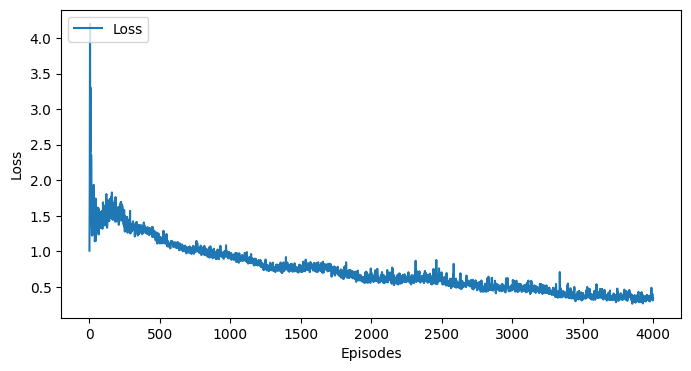

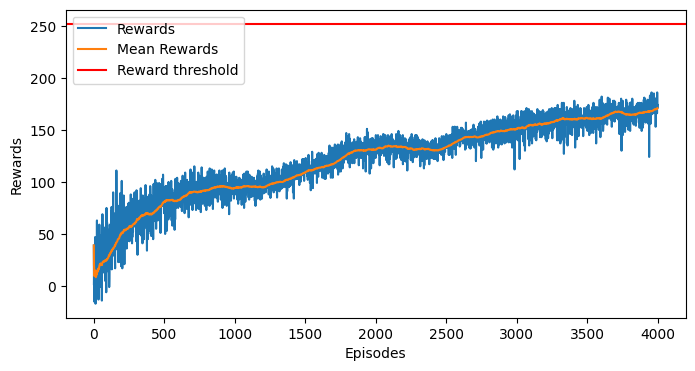

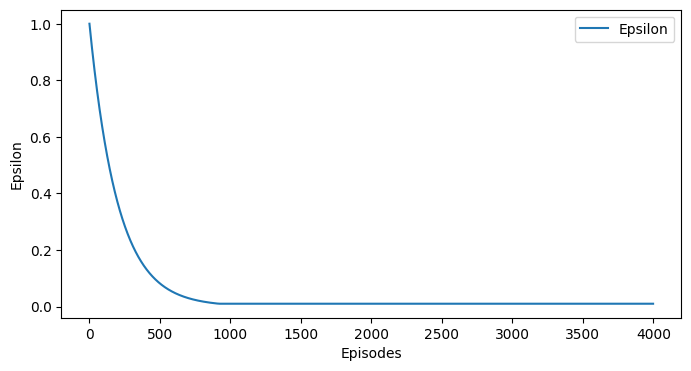

In [ ]:
plot_loss(agentDQN.training_loss)
plot_rewards(agentDQN.training_rewards,agentDQN.mean_training_rewards,REWARD_THRESHOLD)
plot_epsilon(agentDQN.epsilon_evolution)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
#TODO: Afegeix aquí els teus comentaris sobre l'entrenament, l'evolució de recompenses, pèrdues i epsilon.
</div>


Un cop entrenat l'agent, ens interessa comprovar com de bé ha après i si és capaç de superar l'entorn. Per fer-ho, recuperem el model entrenat i deixem que l'agent prengui accions aleatòries segons aquest model per observar el seu comportament.







### 2.5 Test de l'agent

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.5 (0.25 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 505 episodis consecutius en diferents períodes aleatoris des de l'any 2015 fins al 2024. Calcula la suma de recompenses per cada execució. Per aconseguir aquest punt, executa:
<ul>
    <li>Un gràfic amb la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert.</li>
    <li>Emmagatzema la recompensa mitjana obtinguda en les 100 partides a la variable <code>mean_reward_dqn_test</code> i l'última recompensa obtinguda en l'entrenament a <code>mean_reward_dqn_last</code>. També calcula en quants escenaris s'ha obtingut més de 252 dies positius en el trading.</li>
</ul>

A més, realitza l'anàlisi següent amb el model per a l'entorn utilitzat en l'entrenament:
<ul>
    <li>Reproduir una partida completa de l'agent entrenat i mostrar el resultat final, incloent-hi el valor total del portafoli al final de l'episodi.</li>
    <li>Generar un fitxer CSV que registri els resultats de les interaccions de l'agent amb el mercat en cada episodi i mostra per pantalla les últimes 30 accions.</li>
</ul>

<strong>Comenta tots els resultats obtinguts en aquest apartat. A quines conclusions podem arribar? Com podríem millorar l'entrenament i quines implicacions tindria?</strong>
</div>


In [ ]:
import random
import pandas as pd
import numpy as np
# Generar un fitxer CSV que registri els resultats de les interaccions
# de l'agent amb el mercat en cada episodi i mostra per pantalla les últimes 30 accions.
file_path = 'stock_trading_agent_dqn.csv'

# Reproduir una partida completa de l'agent entrenat i mostrar el resultat final,
# incloent-hi el valor total del portafoli al final de l'episodi.
env = ''  # TODO: Assignar l'entorn entrenat

def read_csv_and_show_last_30(file_path):
    try:
        # Llegir el fitxer CSV
        df = pd.read_csv(file_path)

        # Mostrar les últimes 30 accions
        print("Últimes 30 accions del fitxer CSV:")
        print(df.tail(30))
    except FileNotFoundError:
        print(f"El fitxer {file_path} no s'ha trobat.")
    except Exception as e:
        print(f"S'ha produït un error en llegir el fitxer: {e}")

# Exemple d'ús
read_csv_and_show_last_30(file_path)




El fitxer stock_trading_agent_dqn.csv no s'ha trobat.


In [ ]:

# Generar calendari de trading usant dies hàbils
def generate_random_trading_dates(start_range, end_range, trading_days_target=505):
    """
    Genera un parell de dates (start, end) que tinguen exactament trading_days_target dies hàbils.
    """
    start_date = pd.to_datetime(start_range)
    end_date = pd.to_datetime(end_range)

    while True:
        # Seleccionar una data d'inici aleatòria
        random_start = start_date + pd.DateOffset(days=random.randint(0, (end_date - start_date).days - trading_days_target))

        # Generar un rang de dates de trading usant només els dies hàbils
        trading_days = pd.bdate_range(random_start, random_start + pd.DateOffset(days=2 * trading_days_target)).tolist()

        # Filtrar les dates per obtenir exactament el nombre de dies objectiu
        if len(trading_days) >= trading_days_target:
            random_end = trading_days[trading_days_target - 1]  # Últim dia de trading al rang desitjat
            return random_start.strftime("%Y-%m-%d"), random_end.strftime("%Y-%m-%d")

def test_model(agent, base_env, start_range, end_range, trading_days_target=505, win_days_target=252):
    """
    Testeja el model entrenat en 100 episodis amb dates aleatòries de trading.

     Paràmetres:
     - agent: Agent entrenat
     - base_env: Entorn base
     - start_range, end_range: Rangs de dates per generar les dates de trading
     - trading_days_target: Dies de trading per episodi
     - win_days_target: Dies positius requerits per considerar èxit en un episodi

     Retorna:
     - all_rewards: Llista amb les recompenses totals de cada episodi
     - success_rate: Percentatge d'episodis reeixits
    """
    all_rewards = []
    success_count = 0

    for i_episode in range(100):
        # Generar noves dates d'inici i fi aleatòries que compleixin els dies de trading desitjats
        start_date, end_date = generate_random_trading_dates(start_range, end_range, trading_days_target)

        # Actualitzar l'entorn amb les dates noves
        env = StockMarketEnv(ticker='SPY', start=start_date, end=end_date, initial_balance=10000)

        state = env.reset()[0]
        total_reward = 0
        win_days = 0

        while True:
            # L'agent pren una acció
            action = agent.main_network.get_action(state, epsilon=0.0)
            observation, reward, done, truncated, info = env.step(action)

            # Actualitzar recompenses i dies positius
            total_reward += reward
            if reward > 0:
                win_days += 1

            if done:
                break

        all_rewards.append(total_reward)
        if win_days >= win_days_target:
            success_count += 1

        env.close()

    success_rate = success_count / 100
    return all_rewards, success_rate


def plot_test(rewards, th):
    """
    Grafica els resultats del test.
     - rewards: Llista de recompenses totals per episodi
     - th: Llindar de recompensa establert
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Recompenses Totals")
    plt.axhline(y=th, color='r', linestyle='-', label="Llindar de Recompensa")
    plt.xlabel("Episodis")
    plt.ylabel("Recompenses")
    plt.title("Resultats del Test del Model")
    plt.legend()
    plt.show()


In [ ]:
rewards_test_DQNTemp, success_rate = test_model(agentDQN, env, start_range="2015-01-01", end_range="2024-01-01")

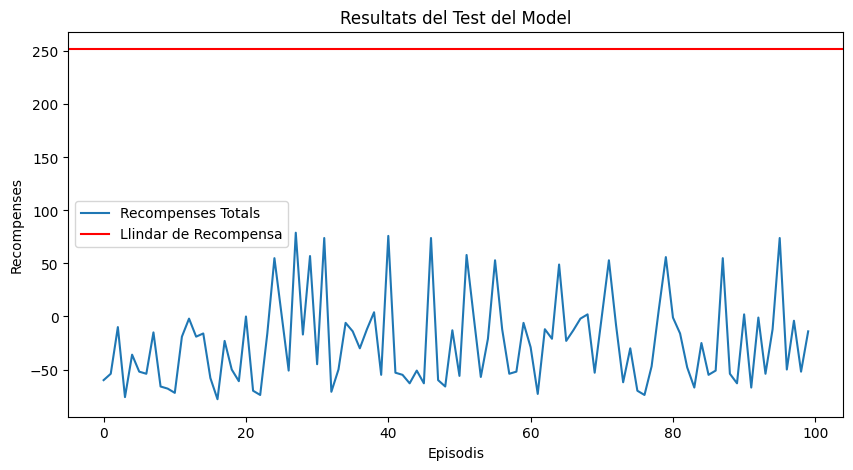

La recompensa mitjana obtinguda per l'agent DQN en les 100 partides de test és: -24.04 punts.
Percentatge d'episodis que van aconseguir guanyar almenys 252 dies: 13.00%


In [ ]:
plot_test(rewards_test_DQNTemp, REWARD_THRESHOLD)

# Calcular la recompensa mitjana de les 100 partides de test
mean_reward_dqn = np.mean(rewards_test_DQNTemp)  # Calcular la mitjana de recompenses obtingudes en el test

# Assignar la Mean Reward de la última iteració de l'entrenament
mean_reward_dqn_last = agentDQN.mean_training_rewards[-1]  # Última recompensa mitjana obtinguda durant l'entrenament

# Resultats
print(f"La recompensa mitjana obtinguda per l'agent DQN en les 100 partides de test és: {mean_reward_dqn:.2f} punts.")
print(f"Percentatge d'episodis que van aconseguir guanyar almenys 252 dies: {success_rate * 100:.2f}%")




<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
#TODO







</div>

## 3. Agent Dueling DQN (1.5 pts)

En aquest apartat resoldrem el mateix entorn amb les mateixes característiques per a l'agent, però utilitzant una dueling DQN. Com en el cas anterior, primer definirem el model de xarxa neuronal, després descriurem el comportament de l'agent, l'entrenarem i, finalment, testejarem el funcionament de l'agent entrenat.



### 3.1 Definició de l'arquitectura de la xarxa neuronal

L'objectiu principal de les dueling DQN és "estalviar-se" el càlcul del valor de Q en aquells estats on l'acció que es prengui sigui irrellevant. Per això, es descompon la funció Q en dos components:

$$Q(s, a) = A(s, a) + V(s)$$

Aquesta descomposició es realitza a nivell de l'arquitectura de la xarxa neuronal. Les primeres capes que teníem a la DQN seran comunes, i després la xarxa es dividirà en dues parts separades definides per la resta de capes.

La descomposició en subxarxes del model de la DQN implementada a l'apartat anterior serà:

<ol>
  <li> Bloc comú: </li>
  <ul>
    <li>Una primera capa completament connectada de 256 neurones i <code>bias = True</code>, amb activació ReLU.</li>
    <li>Una segona capa completament connectada de 128 neurones i <code>bias = True</code>, amb activació ReLU.</li>
  </ul>
  <li>Per a cadascuna de les subxarxes d'avantatge \(A(s,a)\) i valor \(V(s)\):</li>
  <ul>
    <li>Una capa completament connectada de 64 neurones i <code>bias = True</code>, amb activació ReLU.</li>
    <li>Una última capa completament connectada i <code>bias = True</code>. Aquesta serà la nostra capa de sortida, i per tant, el nombre de neurones de sortida dependrà de si es tracta de la xarxa \(A(s,a)\), que tindrà tantes neurones com dimensions tingui l'espai d'accions, o si es tracta de la xarxa \(V(s)\), amb un valor per estat.</li>
  </ul>
</ol>

     


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.1 (0.5 pts):</strong> Implementar la classe <code>duelingDQN()</code>. Inicialitzar les variables necessàries i definir el model de xarxa neuronal indicat.

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi preimplementat. La implementació que es demana a l'enunciat està indicada als blocs <i>#TODO</i> i/o amb variables igualades a <i>None</i>.
</div>



In [ ]:
import torch.autograd as autograd



class duelingDQN(torch.nn.Module):

    def __init__(self, env, device=None, learning_rate=1e-3):

        """
        Paràmetres
        ==========
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'accions possibles
        """

        ###################################
        #### Inicialitzar variables ####
        super(duelingDQN, self).__init__()
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)

        ######

        #######################################
        ## Construcció de la xarxa neuronal
        # Xarxa comuna
        ## Construcció de la xarxa neuronal

        self.model_common = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 256, bias=True),  # Aumentar las neuronas
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),  # Agregar otra capa con más neuronas
            torch.nn.ReLU(),
           ).to(self.device)


        # Subxarxa de la funció de Valor
        # Recordeu adaptar-les a CPU o GPU
        self.fc_layer_inputs = self.feature_size()

        self.value = torch.nn.Sequential(
            torch.nn.Linear(self.fc_layer_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64,1)
        ).to(self.device)

        # Subxarxa de l'Avantatge A(s,a)
        self.advantage  = torch.nn.Sequential(
            torch.nn.Linear(self.fc_layer_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64,self.n_outputs)
        ).to(self.device)

        ## Inicialitzar l'optimitzador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)


    #######################################
    ##### Funció forward #############
    def forward(self, state):
        # Connexió entre capes de la xarxa comuna
        common_out = self.model_common(state)

        # Connexió entre capes de la Subxarxa de Valor
        advantage = self.advantage(common_out)

        # Connexió entre capes de la Subxarxa d'Avantatge
        value = self.value(common_out)


        ## Agregar les dues subxarxes:
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        action = value + advantage - advantage.mean()

        return action
    #######



    ### Mètode e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action = torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(self.device)
        return self.forward(state_t)

    def feature_size(self):
        dummy_input = torch.zeros(1, *env.observation_space.shape).to(self.device)
        return self.model_common(autograd.Variable(dummy_input)).view(1, -1).size(1)


Per al buffer de repetició d'experiències, podem utilitzar exactament la mateixa classe `experienceReplayBuffer` descrita a l'apartat anterior de la DQN.

### 3.2 Definició de l'agent

La diferència entre la DQN i la dueling DQN es centra, com hem vist, en la definició de l'arquitectura de la xarxa. Però el procés d'aprenentatge i actualització és exactament el mateix. Així, podem recuperar la classe implementada a l'apartat anterior, `DQNAgent()`, i reutilitzar-la aquí sota el nom de `duelingDQNAgent()`. L'únic que haurem de fer és afegir l'optimitzador entre les variables a declarar i adaptar la funció de pèrdua al format funcional de PyTorch.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.2 (0.25 pts):</strong> Implementar la classe <code>duelingDQNAgent()</code> com la <code>DQNAgent()</code>
<p>
</p>
De nou, durant el procés s'han d'emmagatzemar (*):
<ul>
    <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
    <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
    <li>La pèrdua durant l'entrenament</li>
    <li>L'evolució de epsilon al llarg de l'entrenament</li>
</ul>

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi preimplementat. La implementació que es demana a l'enunciat està indicada als blocs <i>#TODO</i> i/o amb variables igualades a <i>None</i>, excepte (*) que indica en quin moment emmagatzemar les variables esmentades.
</div>


In [ ]:
class duelingDQNAgent:

    def __init__(self, env, main_network, buffer, reward_threshold, epsilon=0.1, eps_decay=0.99, batch_size=32, device=None):
        """""
        Paràmetres
        ==========
        env: entorn
        target_network: classe amb la xarxa neuronal dissenyada
        target_network: xarxa objectiu
        buffer: classe amb el buffer de repetició d'experiències
        epsilon: epsilon
        eps_decay: decaïment d'epsilon
        batch_size: mida del batch
        nblock: bloc dels X últims episodis dels quals es calcularà la mitjana de recompensa
        reward_threshold: llindar de recompensa definit en l'entorn
        """
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        ##### Inicialitzar variables ######
        self.env = env
        self.main_network = main_network.to(self.device)
        self.target_network = deepcopy(main_network).to(self.device) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100  # Bloc dels X últims episodis dels quals es calcularà la mitjana de recompensa
        self.reward_threshold = reward_threshold  # Llindar de recompensa definit en l'entorn

        self.initialize()

    ##### Inicialitzar variables extres que es necessiten ######
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.epsilon_evolution = []
        self.training_loss = []
        self.state0 = self.env.reset()[0]


    ###### Prendre nova acció ###############################################
    def take_step(self, eps, mode='train'):

        if mode == 'explore':
            # acció aleatòria durant el burn-in o en la fase d'exploració (epsilon)
            action = self.env.action_space.sample()
        else:
            # acció basada en el valor de Q (elecció de l'acció amb millor Q)
            action = self.main_network.get_action(self.state0, eps)
            self.step_count += 1

        # Prendre un 'step', obtenir un nou estat i recompensa. Desar l'experiència al buffer
        new_state, reward, terminated, truncated ,  _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer
        self.state0 = new_state

        # Reiniciar l'entorn si s'ha completat l'episodi ('if done')
        if done:
            self.state0 = env.reset()[0]

        return done

    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250):

        self.gamma = gamma

        # Omplir el buffer amb N experiències aleatòries (burn-in)
        print("Omplint el buffer de repetició d'experiències...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Entrenament...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while not gamedone:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')

                ##### Actualitzar la xarxa principal segons la freqüència establerta #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ### Sincronitzar la xarxa principal i la xarxa objectiu segons la freqüència establerta #####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    # self.sync_eps.append(episode)

                if gamedone:
                    episode += 1

                    ### Calcular la mitjana de recompenses dels últims X episodis i emmagatzemar #####
                    self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    self.training_loss.append(np.mean(self.update_loss))
                    self.update_loss = []

                    ### Comprovar que encara queden episodis. Parar l'aprenentatge si s'arriba al límit


                    print("\rEpisodi {:d} Recompenses Mitjanes {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")

                    # Comprovar si s'ha arribat al límit d'episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nLímit d\'episodis assolit.')
                        print('\nEntorn resolt en {} episodis!'.format(episode))
                        break

                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    # i s'ha entrenat un mínim d'episodis
                    if mean_rewards >= REWARD_THRESHOLD and min_episodios < episode:
                        training = False
                        print('\nReward threshold assolit.')
                        print('\nEntorn resolt en {} episodis!'.format(episode))
                        break

                    ###### Actualitzar epsilon segons la velocitat de decaïment fixada ########
                    self.epsilon_evolution.append(self.epsilon) # guardamos la evolución de epsilon
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

    ## Càlcul de la pèrdua
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).reshape(-1, 1).to(self.device)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1, 1).to(self.device)
        dones_t = torch.tensor(dones, dtype=torch.bool).to(self.device)

        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals).to(self.device)

        # Obtenim els valors de Q de la xarxa objectiu
        next_actions = torch.max(self.main_network.get_qvals(next_states).to(self.device), dim=-1)[1]
        next_actions_vals = next_actions.reshape(-1, 1).to(self.device)
        target_qvals = self.target_network.get_qvals(next_states).to(self.device)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()

        qvals_next[dones_t.bool()] = 0

        # Calculem equació de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        # Funció de pèrdua
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1, 1))
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # Eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size)  # Seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch)  # Calculem la pèrdua
        loss.backward()  # Obtenim els gradients
        self.main_network.optimizer.step()  # Apliquem els gradients a la xarxa neuronal
        # Emmagatzemem els valors de pèrdua
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())


### 3.3 Entrenament del Model

A continuació, entrenarem el model **dueling DQN** amb els mateixos hiperparàmetres amb què vam entrenar la DQN.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.3 (0.25):</strong> Carregar el model de xarxa neuronal i entrenar l'agent amb els mateixos hiperparàmetres utilitzats per a la DQN.
</div>


In [ ]:
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
env = StockMarketEnv()

model = duelingDQN(env, learning_rate = lr)
agentduelingDQN = duelingDQNAgent(env, model, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)
start_time = time.time()
##TODO:

agentduelingDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, min_episodios= 150,
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)
end_time = time.time()
print('Training time: ' + str(round((end_time-start_time)/60,2)) + " minutes")
time_double = round((end_time-start_time)/60,2)

time_ddqn =  str(round((end_time-start_time)/60,2))

Omplint el buffer de repetició d'experiències...
Entrenament...
Episodi 4000 Recompenses Mitjanes 203.73 Epsilon 0.01		6634861955105		
Límit d'episodis assolit.

Entorn resolt en 4000 episodis!
Training time: 49.14 minutes


### 3.4 Anàlisi de l'Entrenament

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.4 (0.25 pts):</strong> Mostrar els mateixos gràfics que amb la DQN:
<ol>
    <li>Recompenses obtingudes al llarg de l'entrenament i l'evolució de les recompenses mitjanes cada 100 episodis, juntament amb el llindar de recompensa establert per l'entorn</li>
    <li>Pèrdua durant l'entrenament</li>
    <li>Evolució de epsilon al llarg de l'entrenament</li>
</ol>
</div>


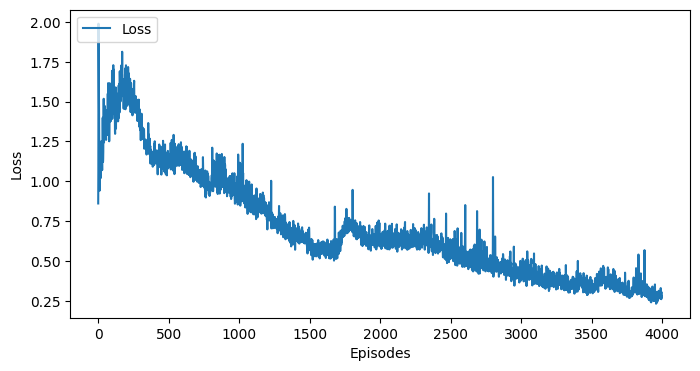

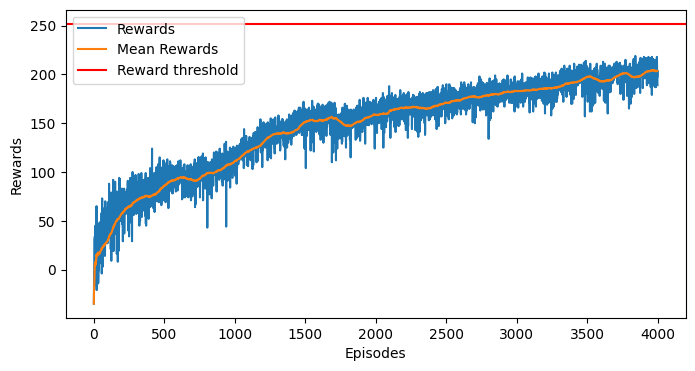

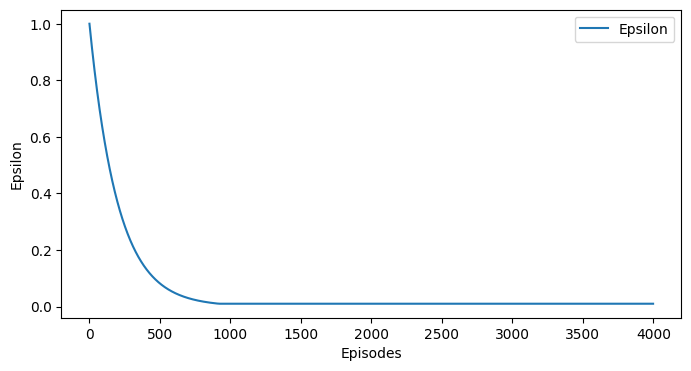

In [ ]:
plot_loss(agentduelingDQN.training_loss)
plot_rewards(agentduelingDQN.training_rewards,agentduelingDQN.mean_training_rewards,REWARD_THRESHOLD)
plot_epsilon(agentduelingDQN.epsilon_evolution)


### 3.5 Test de l'Agent

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.5 (0.25 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 505 episodis consecutius en diferents períodes aleatoris des de l'any 2015 fins al 2024. Calcula la suma de recompenses per cada execució. Per aconseguir aquest punt, executa:
<ul>
    <li>Un gràfic amb la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert.</li>
    <li>Emmagatzema la recompensa mitjana obtinguda en les 100 partides a la variable <code>mean_reward_agentduelingDQN</code> i l'última recompensa obtinguda en l'entrenament a <code>mean_reward_agentduelingDQN_last</code>.</li>
</ul>
A més, realitza l'anàlisi següent amb el model per a l'entorn utilitzat durant l'entrenament:
<ul>
    <li>Reproduir una partida completa de l'agent entrenat i mostrar el resultat final, incloent-hi el valor total del portafoli al final de l'episodi.</li>
    <li>Generar un fitxer CSV que registri els resultats de les interaccions de l'agent amb el mercat en cada episodi i mostrar per pantalla les últimes 30 accions.</li>
</ul>
<strong>Comenta tots els resultats obtinguts en aquest apartat. A quines conclusions podem arribar? Com podríem millorar l'entrenament i quines implicacions tindria?</strong>
</div>


Step: 500
Balance: 212.88876342773438
Shares held: 18
Net worth: 8793.308807373047
Profit: -1206.6911926269531
Últimes 30 accions del fitxer CSV:
     Step  Balance  Shares Held  Net Worth   Profit
970   486   212.89           18    8461.03 -1538.97
971   486   212.89           18    8461.03 -1538.97
972   487   212.89           18    8496.49 -1503.51
973   487   212.89           18    8496.49 -1503.51
974   488   212.89           18    8528.71 -1471.29
975   488   212.89           18    8528.71 -1471.29
976   489   212.89           18    8566.69 -1433.31
977   489   212.89           18    8566.69 -1433.31
978   490   212.89           18    8681.89 -1318.11
979   490   212.89           18    8681.89 -1318.11
980   491   212.89           18    8709.07 -1290.93
981   491   212.89           18    8709.07 -1290.93
982   492   212.89           18    8660.83 -1339.17
983   492   212.89           18    8660.83 -1339.17
984   493   212.89           18    8708.35 -1291.65
985   493   212.89    

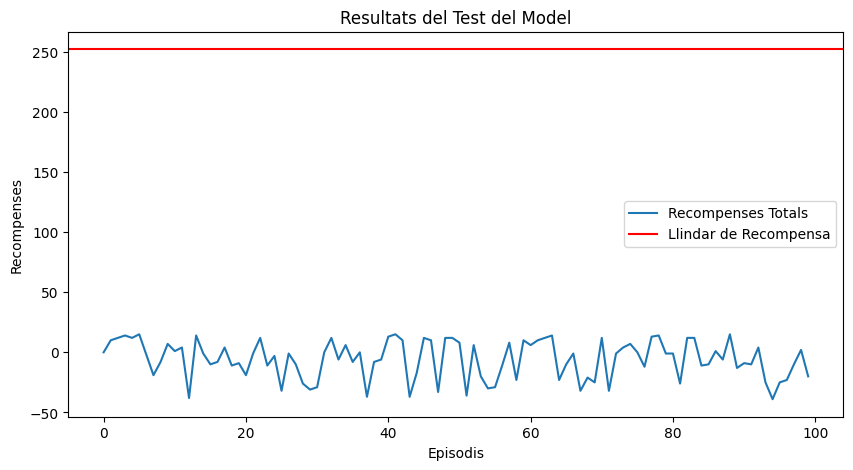

La recompensa mitjana obtinguda per l'agent DQN en les 100 partides de test és: -5.79 punts.


In [ ]:
file_path =  "stock_trading_agent_ddqn.csv"
env = StockMarketEnv(start="2022-01-01", end="2024-01-01", save_to_csv= True,  csv_filename=file_path)

for i_episode in range(1):
        observation = env.reset()[0]
        total_reward = 0
        done = False
        while not done:
            action = agentduelingDQN.main_network.get_action(observation, epsilon=0.0)
            observation, reward, done,terminated, info = env.step(action)
            total_reward += reward
            env.save_to_csv_file()
        env.render()

read_csv_and_show_last_30(file_path)

rewards_test_agentduelingDQN, success_rate = test_model(agentduelingDQN, env, start_range="2022-01-01", end_range="2024-01-01")

plot_test(rewards_test_agentduelingDQN, REWARD_THRESHOLD)

mean_reward_agentduelingDQN = sum(rewards_test_agentduelingDQN) / 100
mean_reward_agentduelingDQN_last = agentduelingDQN.mean_training_rewards[-1]

print(f"La recompensa mitjana obtinguda per l'agent DQN en les 100 partides de test és: {mean_reward_agentduelingDQN:.2f} punts.")



## 4. Comparació dels resultats (1.5 pts)

Ara compararem els resultats. Si has seguit totes les indicacions, hauràs emmagatzemat mètriques bastant interessants que et permetran interpretar els resultats obtinguts.


In [ ]:
# Defineix les dades de la taula
data = [
    ["DQN", mean_reward_dqn_last, mean_reward_dqn, time_dqn],
    ["Dueling DQN", mean_reward_agentduelingDQN_last, mean_reward_agentduelingDQN, time_ddqn],
]

# Defineix els encapçalaments de la taula
headers = ["Agent", "Mitjana Reward d'Entrenament", "Mitjana test amb 100 Partides Aleatòries", "Temps d'entrenament"]

# Imprimeix la taula
table = tabulate(data, headers, tablefmt="pipe")
print(table)


| Agent       |   Mitjana Reward d'Entrenament |   Mitjana test amb 100 Partides Aleatòries |   Temps d'entrenament |
|:------------|-------------------------------:|-------------------------------------------:|----------------------:|
| DQN         |                         170.74 |                                     -24.04 |                 35.94 |
| Dueling DQN |                         203.73 |                                      -5.79 |                 49.14 |


**texto en negrita**<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 4 (1.5 pts):</strong>

Comenta els resultats obtinguts. Quin agent ha obtingut millors resultats? Justifica'l
    
</div>



<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
</div>

In [ ]:
print("Presiona Enter para continuar...")
input()
print("¡Continuamos!")

## 5. Compara els agents en un altre entorn (2 pts)

En aquesta part de la PAC, compararem com es desenvolupa cadascun dels agents en un altre entorn diferent implementat per un tercer.

Un dels beneficis d'haver utilitzat Gymnasium és que podem utilitzar ràpidament els nostres algorismes en qualsevol entorn que comparteixi la mateixa interfície. Un exemple pot ser [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/), un entorn clàssic que consisteix en un carretó sobre el qual s'aguanta una barra vertical. L'objectiu és mantenir la barra en equilibri evitant que caigui, aplicant petites forces al carretó cap a la dreta o cap a l'esquerra. Les úniques accions possibles són aquestes forces, que permeten a l'algorisme aprendre a mantenir l'equilibri de la barra a la posició correcta.

![cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 5 (2 pts):</strong>

Executa l'agent DQN i Dueling DQN en el nou entorn. Un cop ho hagis fet, implementa una taula com la mostrada a l'exercici anterior i analitza els resultats. Continua sent el mateix agent el que ha obtingut millor resultat?
</div>


In [ ]:
import gymnasium as gym
env = gym.make('CartPole-v1')  # Puedes cambiarlo por tu entorno personalizado

# Configuració d'hiperparàmetres per a DQN.
lr = 0.0005             # Velocitat d'aprenentatge ajustada per a una millor convergència
MEMORY_SIZE = 10_000     # Capacitat de memòria reduïda, suficient per a un entorn senzill com CartPole
MAX_EPISODES = 10_000     # Nombre màxim d'episodis reduït, ja que CartPole és un problema més simple
EPSILON = 1             # Valor inicial d'epsilon (alta exploració inicial)
EPSILON_DECAY = 0.999    # Decaïment d'epsilon ajustat per a un descens més gradual
GAMMA = 0.98           # Factor de descompte gamma
BATCH_SIZE = 32         # Mida del lot per a l'entrenament
BURN_IN = 1000           # Episodis inicials per omplir el buffer d'experiència abans d'entrenar
DNN_UPD = 1             # Freqüència d'actualització de la xarxa neuronal (cada pas)
DNN_SYNC = 500         # Freqüència de sincronització de pesos

nn = NeuralNetStockMarket(env, learning_rate=lr)
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

agentDQN = DQNAgent(env, nn, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE)

start_time = time.time()
agentDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES,
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, REWARD_THRESHOLD=env.spec.reward_threshold)
end_time = time.time()

time_dqn = round((end_time-start_time)/60,2)

Omplint el buffer de repetició d'experiències...
Entrenament...
Episodi 5046 Recompenses Mitjanes 475.98 Epsilon 0.01		0868027354544			
Reward threshold assolit.

Entorn resolt en 5046 episodis!


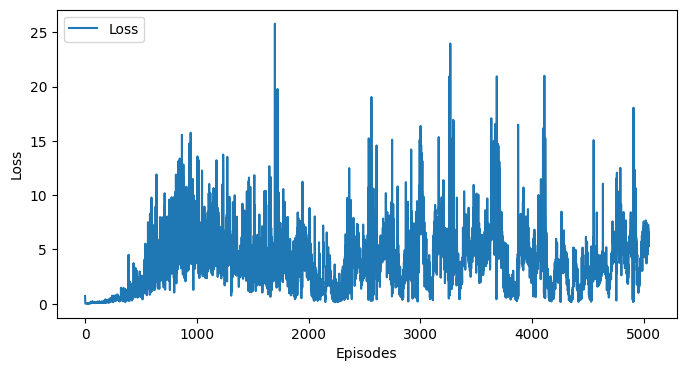

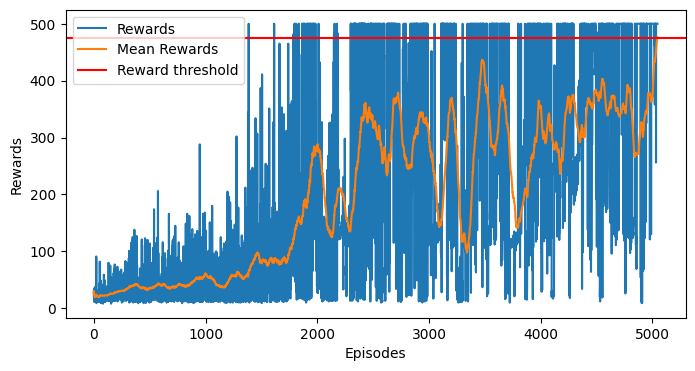

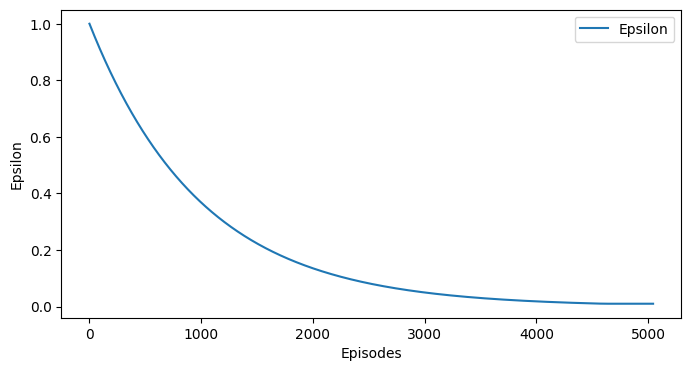

Progreso de episodios: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


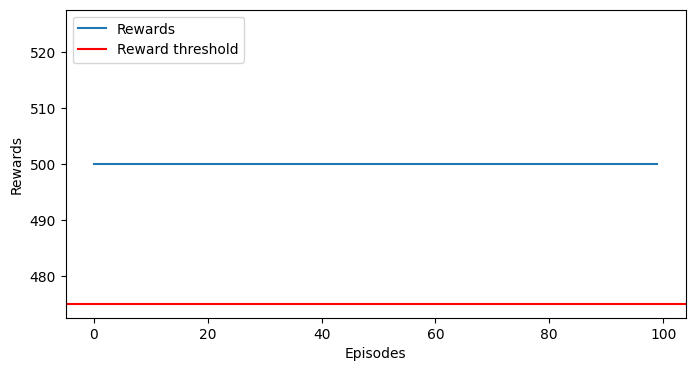

In [ ]:
# Utilitza les funcions anteriors per imprimir l'evolució dels agents.
plot_loss(agentDQN.training_loss)
plot_rewards(agentDQN.training_rewards,agentDQN.mean_training_rewards,env.spec.reward_threshold)
plot_epsilon(agentDQN.epsilon_evolution)

from tqdm import tqdm

def test_model_car(ag, env):
    all_rewards = []
    # Usamos tqdm para el bucle de episodios
    for i_episode in tqdm(range(100), desc="Progreso de episodios"):
        # Actualizar el entorno con las nuevas fechas
        observation = env.reset()[0]
        total_reward = 0
        while True:
            action = ag.main_network.get_action(observation, epsilon=0.0)
            observation, reward, done, truncated, info = env.step(action)
            done = done or truncated
            total_reward += reward
            if done:
                all_rewards.append(total_reward)
                break
        env.close()

    return all_rewards


def plot_test(rewards, th):
    plt.figure(figsize=(8,4))
    plt.plot(rewards, label='Rewards')
    plt.axhline(th, color='r', label="Reward threshold")
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend(loc="upper left")
    plt.show()

rewards_test_DQN = test_model_car(agentDQN,env)
plot_test(rewards_test_DQN, env.spec.reward_threshold)

mean_reward_dqn = np.mean(rewards_test_DQN)
episodes_train_dqn = len(agentDQN.training_rewards)
mean_reward_dqn_last = agentDQN.mean_training_rewards[-1]

In [ ]:
env = gym.make('CartPole-v1')  # Puedes cambiarlo por tu entorno personalizado
lr = 0.0005             # Velocidad de aprendizaje ajustada para mejor convergencia
MEMORY_SIZE = 10_000     # Capacidad de memoria reducida, suficiente para un entorno simple como CartPole
MAX_EPISODES = 10_000     # Número máximo de episodios reducido, ya que CartPole es un problema más sencillo
EPSILON = 1             # Valor inicial de epsilon (alta exploración inicial)
EPSILON_DECAY = 0.999   # Decaimiento de epsilon ajustado para un descenso más gradual
GAMMA = 0.98            # Factor de descuento gamma ligeramente inferior, suficiente para problemas de corto plazo
BATCH_SIZE = 64         # Tamaño del lote para el entrenamiento
BURN_IN = 1000           # Episodios iniciales para llenar el buffer de experiencia antes de entrenar
DNN_UPD = 1             # Frecuencia de actualización de la red neuronal (cada paso)
DNN_SYNC = 1000         # Frecuencia de sincronización de pesos reducida, adecuada para un entorno más rápido como CartPole

REWARD_THRESHOLD = env.spec.reward_threshold
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)
model = duelingDQN(env, learning_rate=lr)

agentduelingDQN = duelingDQNAgent(env, model, buffer, REWARD_THRESHOLD, EPSILON, EPSILON_DECAY, BATCH_SIZE)
start_time = time.time()

agentduelingDQN.train(gamma=GAMMA, max_episodes=MAX_EPISODES, min_episodios= 150,
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)
end_time = time.time()
print('Training time: ' + str(round((end_time-start_time)/60,2)) + " minutes")
time_ddqn = round((end_time-start_time)/60,2)

Omplint el buffer de repetició d'experiències...
Entrenament...
Episodi 5510 Recompenses Mitjanes 478.39 Epsilon 0.01		0868027354544			
Reward threshold assolit.

Entorn resolt en 5510 episodis!
Training time: 52.55 minutes


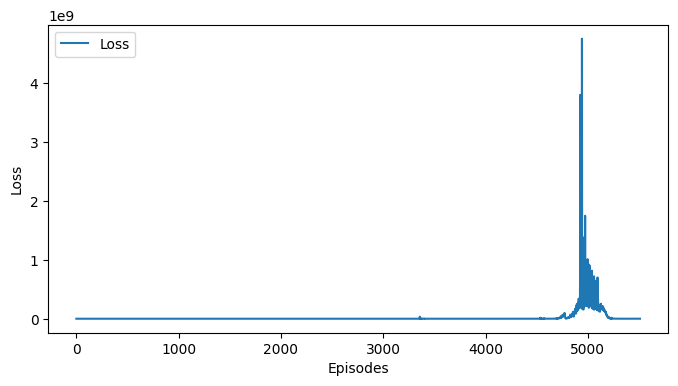

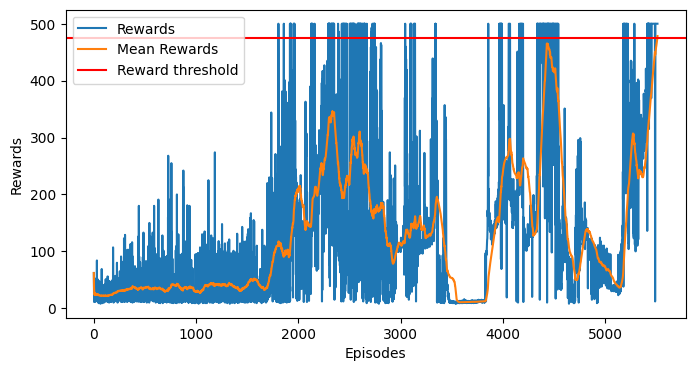

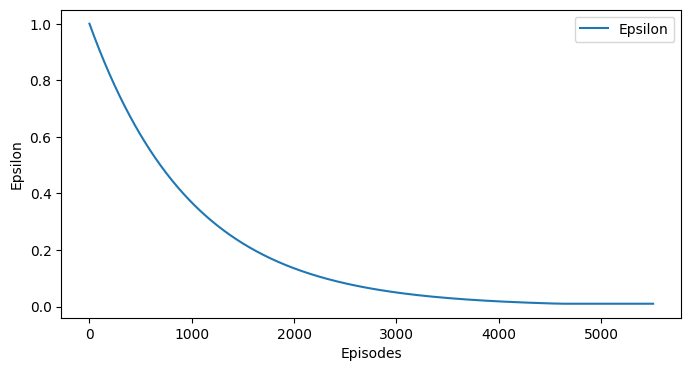

Progreso de episodios: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


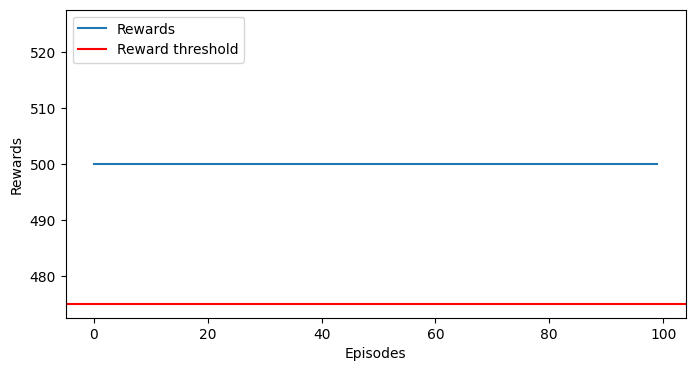

In [ ]:
plot_loss(agentduelingDQN.training_loss)
plot_rewards(agentduelingDQN.training_rewards,agentduelingDQN.mean_training_rewards,REWARD_THRESHOLD)
plot_epsilon(agentduelingDQN.epsilon_evolution)

rewards_test_agentduelingDQN = test_model_car(agentduelingDQN,env)
plot_test(rewards_test_agentduelingDQN, REWARD_THRESHOLD)
mean_reward_agentduelingDQN = np.mean(rewards_test_agentduelingDQN)
episodes_train_duelingdqn=  len(agentduelingDQN.training_rewards)
mean_reward_agentduelingDQN_last = agentduelingDQN.mean_training_rewards[-1]

In [ ]:
# Mostra les dades dels entrenaments de cada agent.
data = [
    ["DQN", mean_reward_dqn_last, mean_reward_dqn, time_dqn],
    ["Dueling DQN", mean_reward_agentduelingDQN_last, mean_reward_agentduelingDQN, time_ddqn],
]

# Defineix els encapçalaments de la taula
headers = ["Agent", "Mitjana Reward d'Entrenament", "Mitjana test amb 100 Partides Aleatòries", "Temps d'entrenament"]

# Imprimeix la taula
table = tabulate(data, headers, tablefmt="pipe")
print(table)


| Agent       |   Mitjana Reward d'Entrenament |   Mitjana test amb 100 Partides Aleatòries |   Temps d'entrenament |
|:------------|-------------------------------:|-------------------------------------------:|----------------------:|
| DQN         |                         475.98 |                                        500 |                 49.06 |
| Dueling DQN |                         478.39 |                                        500 |                 52.55 |
